## Volume averaged Jaccard index estimation for a segmented image and a ground truth image

This notebook may be used for Volume averaged Jaccard index estimation between two segmented images.

In [71]:
import os
import numpy as np
import pandas as pd
import scipy.ndimage as nd
import matplotlib.pyplot as plt

from timagetk.io import imread
from timagetk.components import LabelledImage
from timagetk.visu.util import glasbey

from ctrl.algorithm.image_overlap import fast_image_overlap3d

%matplotlib inline

### Data and parameters

Make sure to modify paths and filenames appropriately to match your file architecture.

In [89]:
main_directory = os.path.dirname(os.getcwd()) # for example

# - Set the predicted segmentation path
target_path = main_directory + '/data/segmentations/fm_paper/original/ps_orig/FM06_t026h_ORIGINAL_PS.inr.gz'

# - Set the ground-truth segmentation path
reference_path = main_directory + '/data/segmentations/fm_paper/gt/FM06_t026h_GT.inr.gz'

In [90]:
slice_index = 50

### Image loading

We assume that the images have the same shape and voxelsize. We also assume that the background label is equal to 1 in all images.

In [75]:
BACKGROUND_LABEL = 1

target_img = LabelledImage(imread(target_path), no_label_id=0)
reference_img = LabelledImage(imread(reference_path), no_label_id=0)

Loading image: /Users/manuelpett/Desktop/GITLAB/data/segmentations/fm_paper/original/ps_orig/FM06_t026h_ORIGINAL_PS.inr.gz
done in 0.201s
Loading image: /Users/manuelpett/Desktop/GITLAB/data/segmentations/fm_paper/gt/FM06_t026h_GT.inr.gz
done in 0.2s


### Image slice visualization

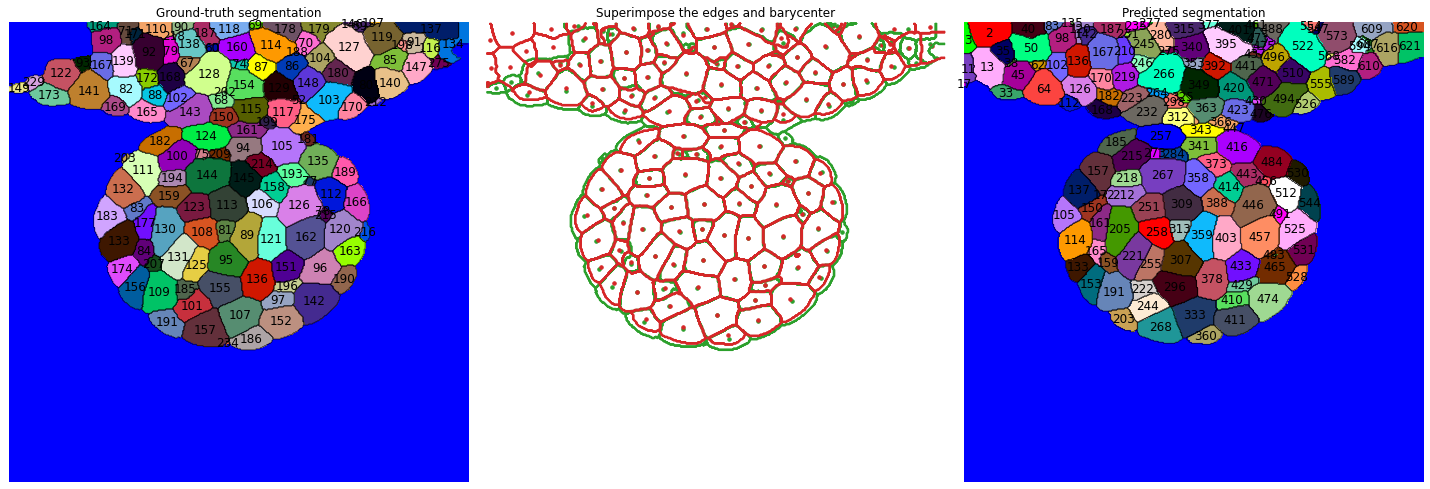

In [76]:
def plot_segmentation(img_seg, title, ax, slice_index, extent):
    slice_img = img_seg.get_array()[:,:,slice_index].T

    barycenter = nd.center_of_mass(np.ones_like(slice_img), slice_img, np.unique(slice_img))
    barycenter = dict(zip(np.unique(slice_img), barycenter * np.array(reference_img.voxelsize[:2])))

    ax.imshow(slice_img%256, cmap='glasbey', vmin=0, vmax=255, extent=extent, interpolation='none')
    ax.set_title(title)

    # - Add contour and label annotation
    for label in np.unique(slice_img):
        if label != 1:
            ax.contour(slice_img == label, linewidths=0.1, extent=extent,
                                 origin='upper', colors='k')
            ax.text(barycenter[label][1],
                              barycenter[label][0],
                              str(label),ha='center',va='center',size=12)
    ax.axis('off')

def plot_contour(img_seg, ax, slice_index, extent, color='r'):
    slice_img = img_seg.get_array()[:,:,slice_index].T

    barycenter = nd.center_of_mass(np.ones_like(slice_img), slice_img, np.unique(slice_img))
    barycenter = dict(zip(np.unique(slice_img), barycenter * np.array(reference_img.voxelsize[:2])))

    ax.imshow(np.zeros_like(slice_img), cmap='Reds', vmin=0, vmax=1, extent=extent, interpolation='none', alpha=0)
    ax.set_title('Superimpose the edges and barycenter')
    
    # - Add contour and label annotation
    for label in np.unique(slice_img):
        if label != 1:
            ax.contour(slice_img == label, extent=extent,
                                 origin='upper', colors=color)
            ax.scatter(barycenter[label][1],
                       barycenter[label][0],
                       s=12, color=color)
    ax.axis('off')
    
figure = plt.figure(0)
figure.clf()

extent = (0, reference_img.extent[0], reference_img.extent[1],0)

# - reference img
figure.add_subplot(1, 3, 1)
plot_segmentation(img_seg=reference_img, title='Ground-truth segmentation',
                  ax=figure.gca(), slice_index=slice_index, extent=extent)

# - superimpose images
figure.add_subplot(1, 3, 2)
plot_contour(img_seg=reference_img, ax=figure.gca(), slice_index=slice_index, extent=extent, color='tab:green')
plot_contour(img_seg=target_img, ax=figure.gca(), slice_index=slice_index, extent=extent, color='tab:red')

# - target img
figure.add_subplot(1, 3, 3)
plot_segmentation(img_seg=target_img, title='Predicted segmentation',
                  ax=figure.gca(), slice_index=slice_index, extent=extent)

figure.set_size_inches(10*2,15)
figure.subplots_adjust(wspace=0,hspace=0)
figure.tight_layout()

### VJI computation

Compute the jaccard index between all possible pairs of overlapping cells in the image.

In [77]:
target_cells = [lab for lab in target_img.labels() if lab != BACKGROUND_LABEL] # avoid background
reference_cells = [lab for lab in reference_img.labels() if lab != BACKGROUND_LABEL] # avoid background

# - Get the jaccard index of pair of reference and target cells
# - Reference and target pair of cells that have no intersection are not returned.
df_jaccard = fast_image_overlap3d(mother_seg=target_img,
                               daughter_seg=reference_img,
                               mother_label = target_cells,
                               daughter_label= reference_cells,
                               method='jaccard', ds=1, verbose=False)
df_jaccard.columns = ['target', 'reference', 'jaccard'] # relabel columns

print(df_jaccard[:15])

    target  reference  jaccard
0        2         53  0.00000
1        2        295  0.00000
2        3        229  0.00000
3        5        229  0.00000
4        5        281  0.00000
5        5        309  0.00959
6        5        424  0.01384
7        5        463  0.02778
8        5        487  0.01046
9        5        488  0.00000
10       5        516  0.05666
11       5        520  0.00000
12       5        607  0.00000
13       5        613  0.00000
14       5        746  0.01867


Identify for each reference cell, the target cell that maximize their jaccard index.

In [78]:
# - For each reference labels find the target labels that maximize the jaccard index
df_jaccard = df_jaccard.loc[df_jaccard.groupby('reference')['jaccard'].idxmax()]
print(df_jaccard[:5])

      target  reference  jaccard
9353     553          3  0.61311
9977     591          4  0.50794
3327     216          5  0.26434
5260     327          6  0.08626
2241     154          7  0.13321


Add the missing reference cells (no intersection with any target cells) and calculate the volume of each reference cells.

In [79]:
# - Assert that all the reference labels are in the dataframe (if a reference cell is totally included
#   in the target background it wont appear)
missing_cells = set(reference_cells) - set(df_jaccard.reference.values)

if len(missing_cells) > 0:
    # - add them with a jaccard index of 0
    for lab in missing_cells:
        df_jaccard = df_jaccard.append({'target': 0, 'reference': lab, 'jaccard': 0}, ignore_index=True)

# - Add the corresponding volumes (in voxel unit)
cell_ref_volume = nd.sum(np.ones_like(reference_img), reference_img, reference_img.labels())
cell_ref_volume = {lab: vol for lab, vol in zip(reference_img.labels(), cell_ref_volume)}

df_jaccard['volume'] = df_jaccard.apply(lambda x: cell_ref_volume[x.reference], axis=1)
print(df_jaccard[:5])

      target  reference  jaccard  volume
9353     553          3  0.61311  1962.0
9977     591          4  0.50794   295.0
3327     216          5  0.26434  8258.0
5260     327          6  0.08626  2764.0
2241     154          7  0.13321  1180.0


Calculate the weighted jaccard index by multiplying the jaccard index by the cell volume.

In [80]:
df_jaccard['weighted_jaccard'] = df_jaccard.jaccard * df_jaccard.volume
print(df_jaccard[:5])

      target  reference  jaccard  volume  weighted_jaccard
9353     553          3  0.61311  1962.0        1202.92182
9977     591          4  0.50794   295.0         149.84230
3327     216          5  0.26434  8258.0        2182.91972
5260     327          6  0.08626  2764.0         238.42264
2241     154          7  0.13321  1180.0         157.18780


The volume averaged jaccard index is obtained by summing all the weighted jaccard index and divide them by the total volume of the ground-truth tissue.

In [84]:
total_cell_volume = sum(df_jaccard.volume.values)
sum_weighted_ji = sum(df_jaccard.weighted_jaccard.values)
vji = sum_weighted_ji / total_cell_volume
print(f'Reference img: {os.path.basename(reference_path)} \nTarget img: {os.path.basename(target_path)}')
print(f"Volume average jaccard index : {np.around(vji, 5)}")

Reference img: FM06_t026h_GT.inr.gz 
Target img: FM06_t026h_ORIGINAL_PS.inr.gz
Volume average jaccard index : 0.81998


## Save the output Jaccard index for each cell in a .csv file. 
Note that you will need this CSV file for 3D visualization of segmentation quality using Morphonet

In [88]:
save_directory = main_directory # set the save folder

df_jaccard.to_csv(main_directory + '/ji_results.csv', index=False)